### Part I: Imports of various modules and pretrained embedding models

In [1]:
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd
import re
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import matplotlib.style #Some style 
import matplotlib as mpl #Some more style 
drive.mount('/content/drive')

path ='/content/drive/My Drive/Colab Notebooks/dest'

os.chdir(path)
os.listdir(path)

raw_text=pd.read_csv('mesh.csv')
print(np.size(raw_text))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
81222


In [2]:
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
## More imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TextVectorization

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from spacy.lang.en import English
import spacy
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#import gensim models

from gensim.models import fasttext
from gensim.models import KeyedVectors
from gensim.models import Word2Vec 
# -------- Pretrain embeddings ------ 


def load_fasttext():
  ft_file = "cache/cc.en.100.bin"
  print(f'>>> Load FastText from {ft_file}', end=' ')
  start_time = datetime.datetime.now() 
  ft_cc = fasttext.load_facebook_vectors(ft_file) 
  time_elapsed = datetime.datetime.now() - start_time 
  print(f'| Took: {time_elapsed} sec')
  return ft_cc

def load_glove():
    print('>>> Load GloVe')
    start_time = datetime.datetime.now()
    word2vec_model_path = 'cache/glove.6B.50d.txt' 

    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=False,unicode_errors='ignore',encoding='utf-8')
    word2vec_model.init_sims(replace=True)
    time_elapsed = datetime.datetime.now() - start_time 
    print(f'| Took: {time_elapsed}')
    return word2vec_model

def load_word2vec():
    saved_embeddings = 'cache/word2vec_100.model'
    if os.path.exists(saved_embeddings):
        print('>>> Load Word2Vec')
        wv_model = Word2Vec.load(saved_embeddings).wv
    else:
        wv_model = gensim.downloader.load('word2vec-google-news-300')
    return wv_model 

In [26]:

def plot_performance(history,batch_size):
  fig, axs = plt.subplots(1, 2, figsize=(20, 8))
  
  # Plot data on the first subplot
  axs[0].plot(history.history['val_loss'],'.--',label='Valid Loss')
  axs[0].plot(history.history['loss'],'.--',label='Training Loss')
  axs[0].set_title('Model Loss for the Fast Text Embedding (batch size={})'.format(batch_size))
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(loc='best')
  # Plot data on the second subplot
  axs[1].plot(history.history['val_acc'],'.--',label='Valid Accuracy')
  axs[1].plot(history.history['acc'],'.--',label='Training Accuracy')
  axs[1].set_title('Model Accuracy for the Fast Text Embedding (batch size={})'.format(batch_size))
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(loc='best')

  # Adjust the layout
  fig.tight_layout()
  plt.show()

In [6]:
raw_text['Text'][0]

'a white north american girl with clinical features of the mucocutaneous lymph node syndrome had a myocardial infarct and angiographic evidence of a coronary artery aneurysm and mitral regurgitation. the mucocutaneous lymph node syndrome has been extensively diagnosed in japan in recent years. it appears to be a distinct entity, although not precisely separated from polyarteritis nodosa in childhood. the condition may be more common than previously realized.'

### Part II: Drop NAs values and shuffle the data; 

In [7]:
raw_text.dropna(inplace=True)
raw_text=raw_text.sample(frac=1).reset_index(drop=True)



In [8]:
raw_text.head(15)

,label,path,Text
0,Lacrimal Apparatus Diseases,../data/pubmed_abstracts/8055764.txt,dacryocystorhinostomy (dcr) was done in five p...
1,Eye Injuries,../data/pubmed_abstracts/29170837.txt,background: carotid-cavernous fistula (ccf) is...
2,Uveal Diseases,../data/pubmed_abstracts/17899969.txt,the wagr syndrome is a multiple congenital ano...
3,Eye Neoplasms,../data/pubmed_abstracts/9195780.txt,waldenstroem's macroglobulinemia is usually cl...
4,Pupil Disorders,../data/pubmed_abstracts/16500125.txt,we present a case series of five children with...
5,"Eye Diseases, Hereditary",../data/pubmed_abstracts/23533165.txt,the authors describe 2 patients with early inf...
6,Vision Disorders,../data/pubmed_abstracts/26468224.txt,progressive subretinal fibrosis with uveitis (...
7,Eye Abnormalities,../data/pubmed_abstracts/7434062.txt,this case of bilateral clinical anophthalmia p...
8,Corneal Diseases,../data/pubmed_abstracts/17172907.txt,purpose: to report the clinico-pathologic feat...
9,Ocular Motility Disorders,../data/pubmed_abstracts/9640838.txt,a case of opsoclonus-myoclonus occurring in a ...


### Part III: Clean and Tokenise the Raw Text

In [9]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

class Token():

  
  def clean_text(self,text):
      """
          text: a string
          
          return: modified initial string
      """
      text = text.lower() # lowercase text
      text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
      text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
      text = text.replace('x', '')
  #    text = re.sub(r'\W+', '', text)
      text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
      return text




  def tokenise(self,document, remove_stop = True):
    '''
    Clean a document and return tokens
    Input: string, document 
    Output: normalised list of tokens from document    
    '''
    cleaned = re.sub(r'[^\w\s_]+|\d+', '', document).strip().lower() # remove numbers because queries don't contain numbers
    tokenised = [str(tok).lower() for tok in word_tokenize(document)] # tokenise document
    if remove_stop == True:
        tokenised = [token for token in tokenised if token not in stop_words] # remove stopwords
    return tokenised



T=Token()

In [10]:
raw_text['Text'] = raw_text['Text'].apply(T.clean_text)
raw_text['Text'] = raw_text['Text'].str.replace('\d+', '')

<ipython-input-10-bb05171f0859>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_text['Text'] = raw_text['Text'].str.replace('\d+', '')


In [11]:
#Check the tokenised clean text

raw_text['Text'][0]

'dacryocystorhinostomy dcr done five patients mulago hospital   reasonable cure rate realised based favourable results cases recommended dacryocystorhinostomy considered earlier repeated syringing probing fail clear epiphora due irreversible nasal lacrimal duct obstruction'

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


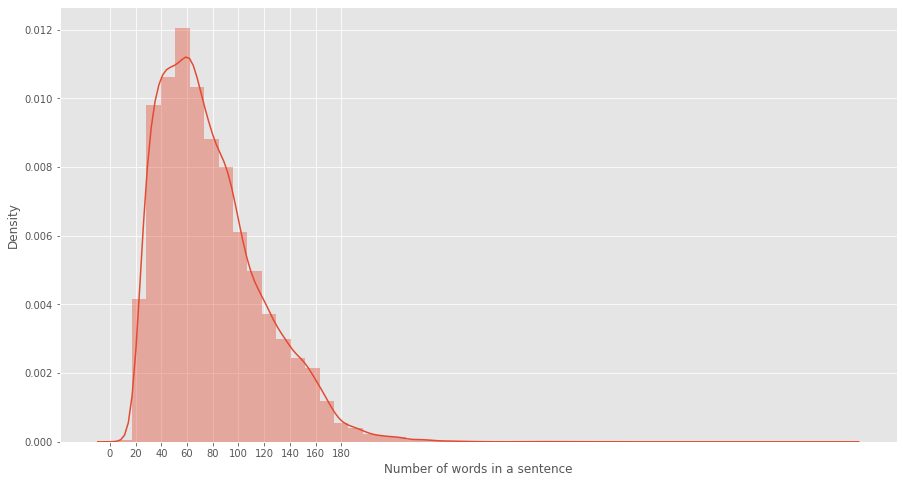

In [12]:
length_list=[]

for s in raw_text['Text']:
  s=s.split()
  length_list.append(len(s))

import seaborn as sns
plt.style.use('ggplot')

plt.figure(figsize = (15,8))
sns.distplot(length_list)
x_ticks = range(0, 200,20)
plt.xlabel('Number of words in a sentence')
plt.xticks(x_ticks)
plt.show()

In [13]:
#density of each token
fdist = FreqDist(raw_text['Text'])
#fdist
num_unique_tokens = fdist.B()
print('the number of unique tokens is',num_unique_tokens)

the number of unique tokens is 27037


### Part IV: HOT ENCODE the LABELs (get Ys) & Overview of the provided data

In [14]:
Y = pd.get_dummies(raw_text['label']).values
print('Shape of label tensor:', Y.shape)
Y[:15]

Shape of label tensor: (27073, 21)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [15]:
import seaborn as sns
df=raw_text.label.value_counts().rename_axis('MeSH Term').reset_index(name='Counts')
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = df.columns
for row in df.itertuples():
    x.add_row(row[1:])
print(x)

+-----------------------------+--------+
|          MeSH Term          | Counts |
+-----------------------------+--------+
|       Retinal Diseases      |  4056  |
|       Orbital Diseases      |  2776  |
|       Vision Disorders      |  2542  |
|  Ocular Motility Disorders  |  2508  |
|       Eyelid Diseases       |  1998  |
|     Optic Nerve Diseases    |  1809  |
|       Corneal Diseases      |  1756  |
|        Uveal Diseases       |  1291  |
|   Eye Diseases, Hereditary  |  1245  |
|        Eye Infections       |  1149  |
|        Eye Neoplasms        |  917   |
|      Eye Abnormalities      |  859   |
|        Lens Diseases        |  828   |
|    Conjunctival Diseases    |  750   |
| Lacrimal Apparatus Diseases |  596   |
|     Ocular Hypertension     |  577   |
|      Refractive Errors      |  466   |
|         Eye Injuries        |  435   |
|       Scleral Diseases      |  201   |
|       Pupil Disorders       |  188   |
|        Eye Hemorrhage       |  126   |
+---------------

In [16]:
raw_text.loc[raw_text['label'] == 'Retinal Diseases', 'LABEL'] = 0
raw_text.loc[raw_text['label'] == 'Orbital Diseases', 'LABEL'] = 1
raw_text.loc[raw_text['label'] == 'Vision Disorders', 'LABEL'] = 2
raw_text.loc[raw_text['label'] == 'Ocular Motility Disorders', 'LABEL'] = 3
raw_text.loc[raw_text['label'] == 'Eyelid Diseases', 'LABEL'] = 4
raw_text.loc[raw_text['label'] == 'Optic Nerve Diseases', 'LABEL'] = 5
raw_text.loc[raw_text['label'] == 'Corneal Diseases', 'LABEL'] = 6
raw_text.loc[raw_text['label'] == 'Uveal Diseases', 'LABEL'] = 7
raw_text.loc[raw_text['label'] == 'Eye Diseases, Hereditary', 'LABEL'] = 8
raw_text.loc[raw_text['label'] == 'Eye Infections', 'LABEL'] = 9
raw_text.loc[raw_text['label'] == 'Eye Neoplasms', 'LABEL'] = 10
raw_text.loc[raw_text['label'] == 'Eye Abnormalities', 'LABEL'] = 11
raw_text.loc[raw_text['label'] == 'Lens Diseases', 'LABEL'] = 12
raw_text.loc[raw_text['label'] == 'Conjunctival Diseases', 'LABEL'] = 13
raw_text.loc[raw_text['label'] == 'Lacrimal Apparatus Diseases', 'LABEL'] = 14
raw_text.loc[raw_text['label'] == 'Ocular Hypertension', 'LABEL'] = 15
raw_text.loc[raw_text['label'] == 'Refractive Errors', 'LABEL'] = 16
raw_text.loc[raw_text['label'] == 'Eye Injuries', 'LABEL'] = 17
raw_text.loc[raw_text['label'] == 'Scleral Diseases', 'LABEL'] = 18
raw_text.loc[raw_text['label'] == 'Pupil Disorders', 'LABEL'] = 19
raw_text.loc[raw_text['label'] == 'Eye Hemorrhage', 'LABEL'] = 20



In [17]:
print('There are {} row of data in total'.format(len(raw_text['Text'])))

There are 27073 row of data in total


### Part V:Train-test split and Preparing Embedding Matrix


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(raw_text['Text'], Y, test_size=0.2, random_state=42)
print((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)) #check if the shape matches


((21658,), (21658, 21), (5415,), (5415, 21))


In [19]:
vectorizer = TextVectorization(max_tokens=50000, output_sequence_length=64)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2


# Prepare embedding matrix
def create_embedding_matrix(model,word_index,embedding_dim):
  hits = 0
  misses = 0
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      try:
        embedding_vector = model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1

      except:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [20]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
y_train = np.array(Y_train)

x_test=vectorizer(np.array([[s] for s in X_test])).numpy()
y_test=np.array(Y_test)


In [21]:
def lstm_model(embedding_matrix,batch_size,embedding_dim):
  model = Sequential()
  model.add( Embedding(
      num_tokens,
      embedding_dim,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix), ))
  model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
  model.add(Dense(21, activation='softmax'))
  model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['acc'])
  print(model.summary())
  return model



### Part VI: Loading the Pretrained 'Glove' model to the Embedding Layer

In [29]:
#load glove model
glove=load_glove()

>>> Load GloVe


<ipython-input-4-9157b67ea9e7>:24: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  word2vec_model.init_sims(replace=True)


| Took: 0:00:11.367412


In [30]:
emb_matrix_glove=create_embedding_matrix(glove,word_index,embedding_dim)

Converted 24630 words (24140 misses)


In [31]:
batch_size = 256
epochs = 25
glove_model=lstm_model(emb_matrix_glove,batch_size,50)

history_gl_256 = glove_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          2438600   
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 21)                1365      
                                                                 
Total params: 2,469,405
Trainable params: 2,469,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
68/68 [==============================] - 23s 295ms/step - loss: 2.7892 - acc: 0.1452 - val_loss: 2.7899 - val_acc: 0.1440
Epoch 2/25
68/68 [==============================] - 20s 298ms/step - loss: 2.6509 - acc: 0.1717 - val_loss: 2.6850 - val_acc: 0.1681
Epoch 3/25
68/68 [===================

170/170 [==============================] - 4s 21ms/step - loss: 1.1483 - acc: 0.7102
---Evaluated Test set result---
  Loss: 1.148
  Accuracy: 0.710


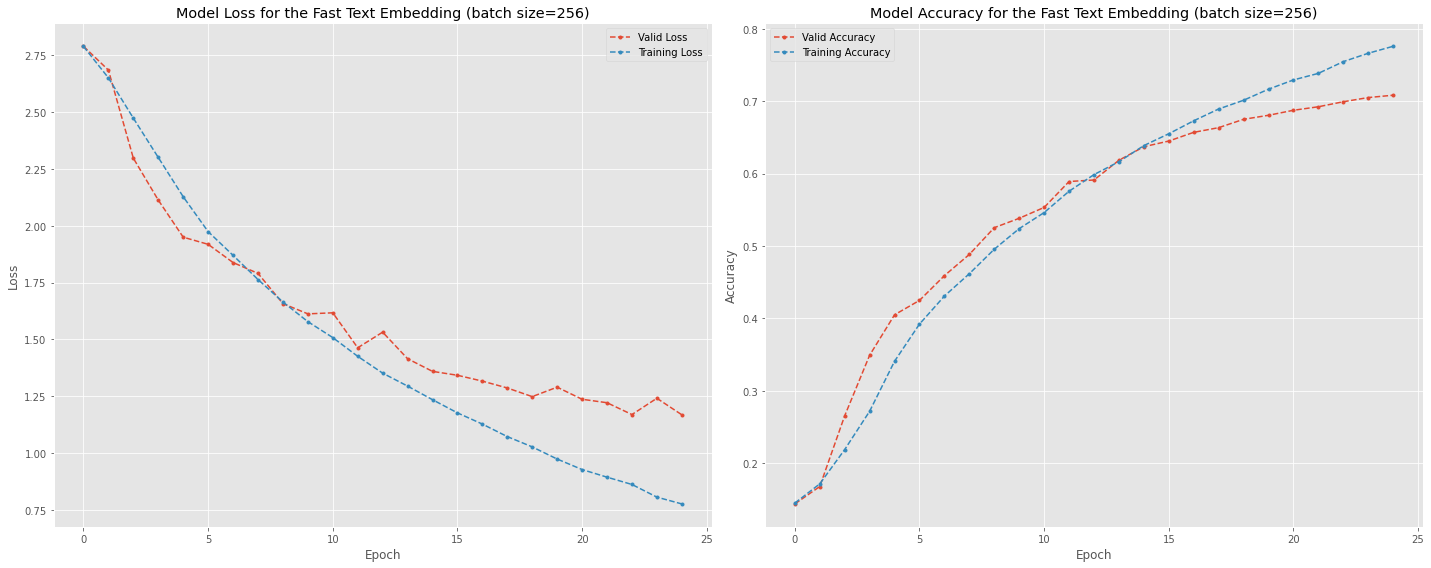

In [32]:
accr = glove_model.evaluate(x_test,y_test)
print('---Evaluated Test set result---\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
plot_performance(history_gl_256,256)


### Part VII: Loading the Pretrained 'Fasttext' model to the Embedding Layer

In [22]:
Ft_model=load_fasttext()


>>> Load FastText from cache/cc.en.100.bin | Took: 0:01:34.700325 sec


In [23]:
embedding_dim_ft=100
emb_matrix_FT=create_embedding_matrix(Ft_model,word_index,embedding_dim_ft)

Converted 48770 words (0 misses)


In [33]:
batch_size=512
epochs=25
ft_model_512=lstm_model(emb_matrix_FT,batch_size,100)
history_ft_512 = ft_model_512.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         4877200   
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 21)                1365      
                                                                 
Total params: 4,920,805
Trainable params: 4,920,805
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
34/34 [==============================] - 16s 406ms/step - loss: 2.8101 - acc: 0.1454 - val_loss: 2.7731 - val_acc: 0.1440
Epoch 2/25
34/34 [==============================] - 12s 344ms/step - loss: 2.6715 - acc: 0.1739 - val_loss: 2.4824 - val_acc: 0.2218
Epoch 3/25
34/34 [===================

170/170 [==============================] - 4s 21ms/step - loss: 1.3793 - acc: 0.6536
---Evaluated Test set result---
  Loss: 1.379
  Accuracy: 0.654


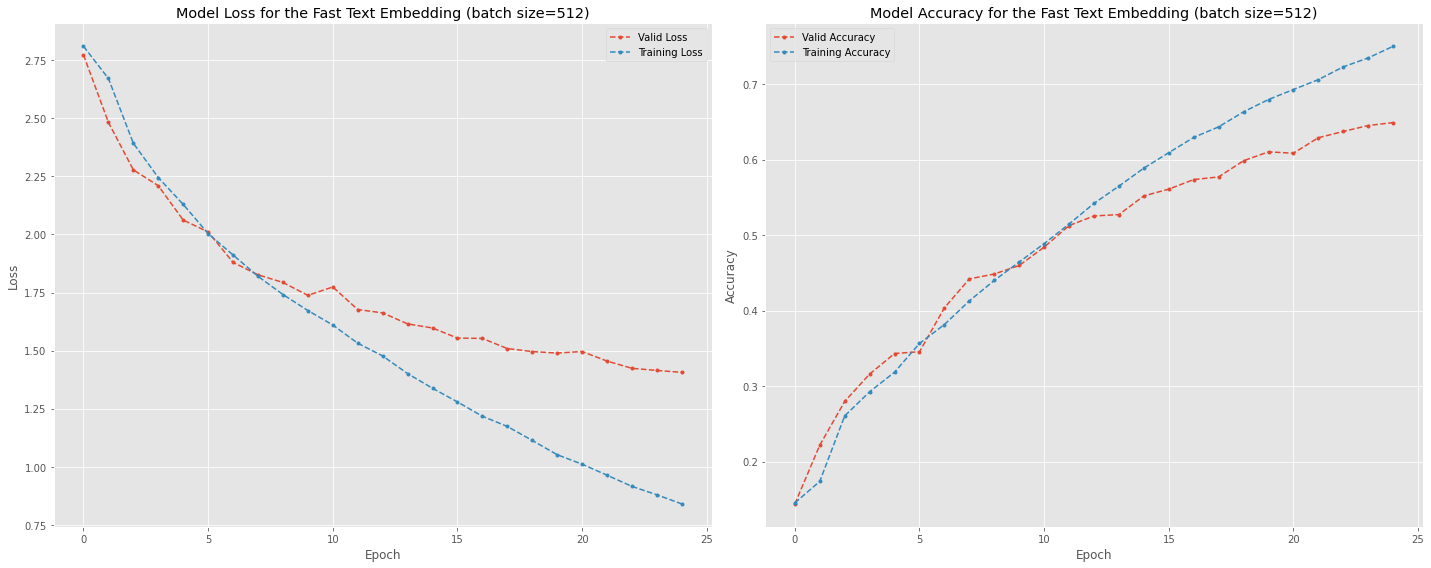

In [34]:
accr = ft_model_512.evaluate(x_test,y_test)
print('---Evaluated Test set result---\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
plot_performance(history_ft_512,512)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         4877200   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 21)                1365      
                                                                 
Total params: 4,920,805
Trainable params: 4,920,805
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
68/68 [==============================] - 27s 304ms/step - loss: 2.7727 - acc: 0.1481 - val_loss: 2.7637 - val_acc: 0.1429
Epoch 2/25
68/68 [==============================] - 22s 328ms/step - loss: 2.5026 - acc: 0.2296 - val_loss: 2.4292 - val_acc: 0.2765
Epoch 3/25
68/68 [===================

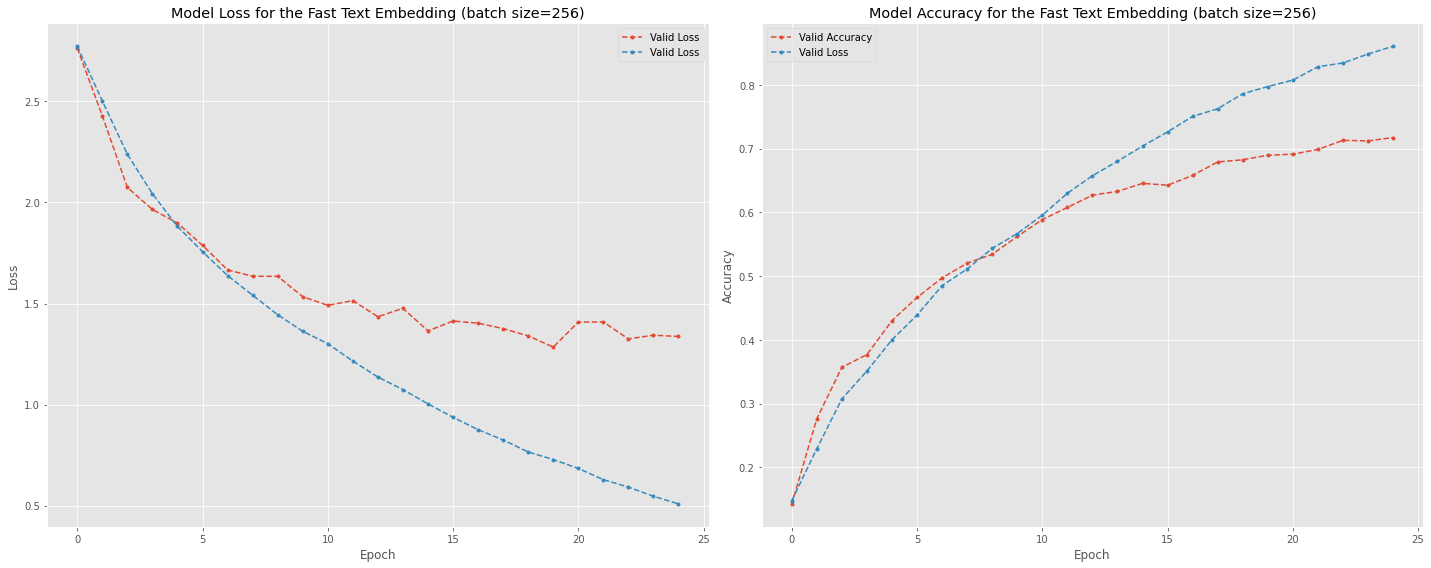

In [25]:
batch_size=256
epochs=25
ft_model_256=lstm_model(emb_matrix_FT,batch_size,100)
history_ft_256 = ft_model_256.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])




170/170 [==============================] - 4s 21ms/step - loss: 1.3049 - acc: 0.7173
---Evaluated Test set result---
  Loss: 1.305
  Accuracy: 0.717


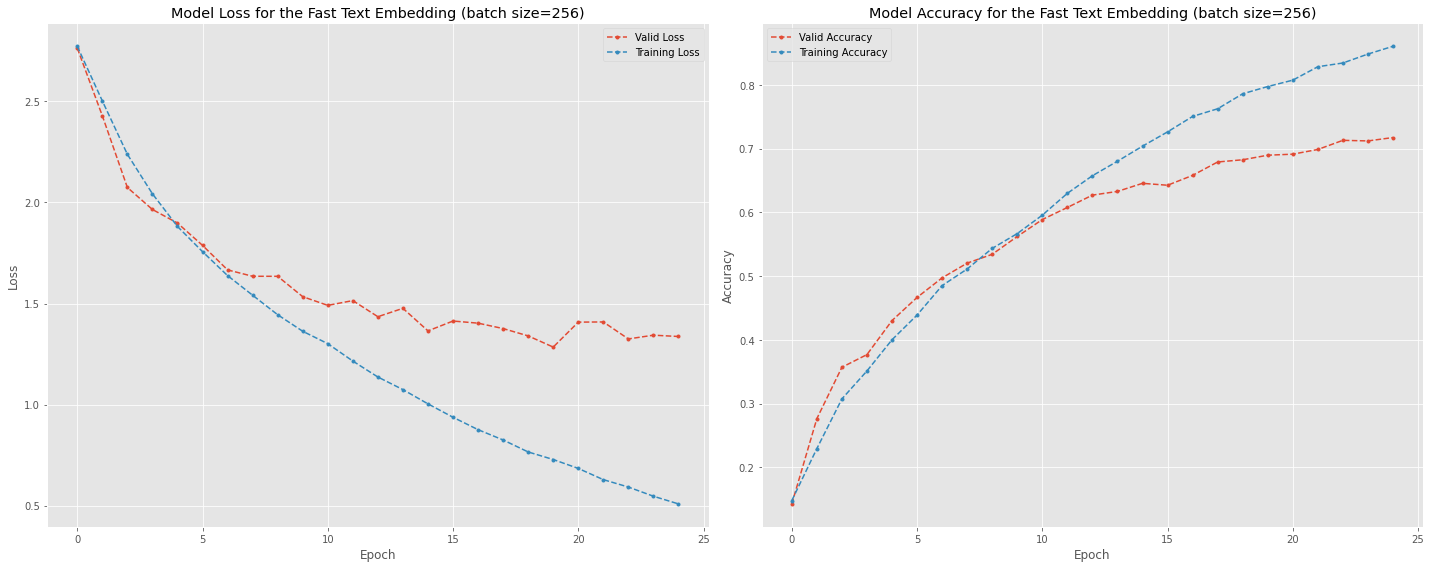

In [28]:
accr = ft_model_256.evaluate(x_test,y_test)
print('---Evaluated Test set result---\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
plot_performance(history_ft_256,256)

In [35]:
batch_size=128
epochs=25
ft_model_128=lstm_model(emb_matrix_FT,batch_size,100)
history_ft_128 = ft_model_128.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         4877200   
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 21)                1365      
                                                                 
Total params: 4,920,805
Trainable params: 4,920,805
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
136/136 [==============================] - 45s 308ms/step - loss: 2.7085 - acc: 0.1669 - val_loss: 2.4379 - val_acc: 0.2378
Epoch 2/25
136/136 [==============================] - 41s 299ms/step - loss: 2.3202 - acc: 0.2793 - val_loss: 2.3205 - val_acc: 0.2994
Epoch 3/25
136/136 [=============

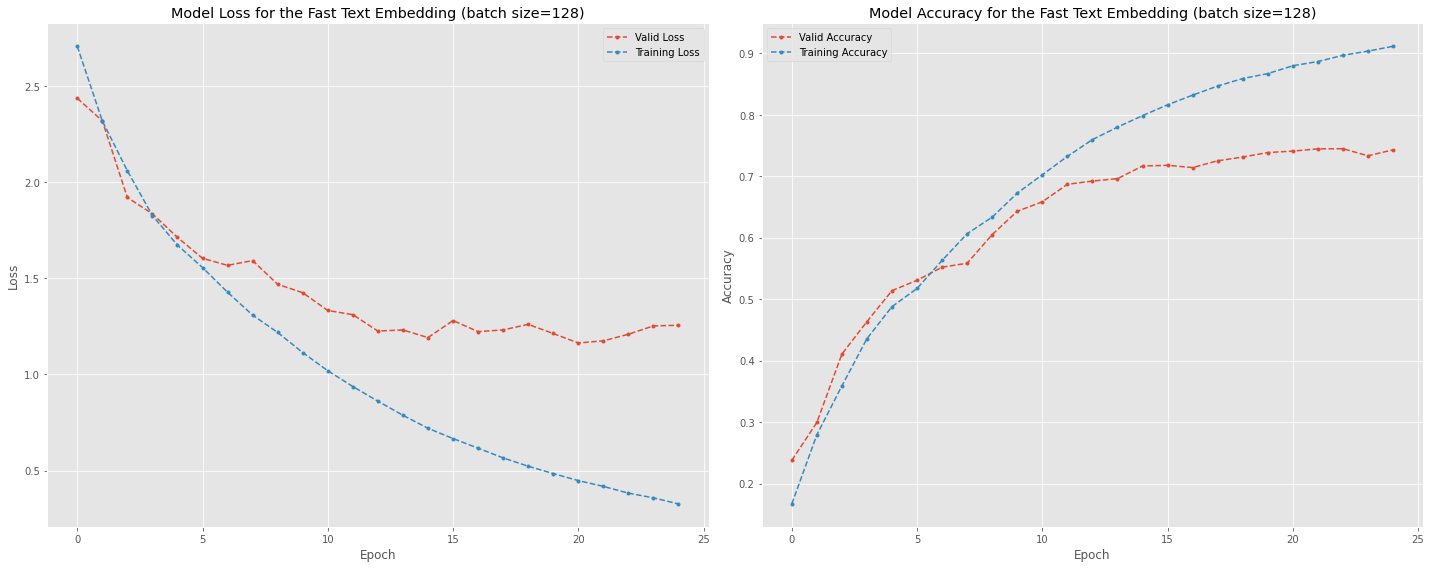

In [36]:
plot_performance(history_ft_128,128)

In [37]:
accr = ft_model_128.evaluate(x_test,y_test)
print('---Evaluated Test set result---\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


170/170 [==============================] - 4s 21ms/step - loss: 1.2191 - acc: 0.7357
---Evaluated Test set result---
  Loss: 1.219
  Accuracy: 0.736


### Word2Vec model
onley 10 words are converted, therefore this embedding is not tested.


In [31]:
w2v=load_word2vec()

>>> Load Word2Vec


In [33]:
embedding_dim_w2v=100
emb_matrix_FT=create_embedding_matrix(w2v,word_index,embedding_dim_w2v)

Converted 10 words (48513 misses)
